## Part 1. Initialization

In [1]:
# 1 Initialization
import numpy as np
import skimage
import matplotlib.pyplot as plt
import matplotlib.colors as c
import os
import mpmath
from astropy.io import fits
from datetime import datetime
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.signal import convolve2d
import sympy as sp
from tqdm import tqdm
from math import sqrt, sin, cos, acos, atan, tanh

## Part 2. Defining the Nebula

In [2]:
# 2 Important Parameters
observing_latitude_degrees = 24 # degrees, Observing latitude - Default : 25
view_length = 6e17 # cm, Length of the display box - Default : 6e17
distance_ly = 8000 # ly, Distance to the lebula - Default : 8000
resolution = 500 # Number of pixels of one side of the display - Default : 200
pixel_size = 0.1013 / 2.196257815841434 # Arcseconds
distance_steps = 3000 # Number of distance steps in the optical depth center array - Default : 3000
angle_steps = 1800 # Number of angle steps in the optical depth center array - Default : 1800
absorption_steps_center = 1 # Number of steps between two adjacent elements of the spherical optical depth array - Default : 10
absorption_steps = 5 # Number of steps between two adjacent elements in the cubical optical depth array - Default : 5

In [3]:
# 3 Nebula Shape Parameters
rin = 2e16 # cm, Radius where we stop worrying about inner cutoff
density_enhancement = 15 # Density enhancement factor in the lobe walls - Default : 7
edge_thickness = 0.2 # The thickness factor of the edge relative to the size of the lobe - Default : 0.12
eccentricity = 0.72 # Eccentricity of the conic shaped lobe - Default : 0.85
focus_shift = view_length * 0.013 # Coordinate of the conic section edge - Default : 0
focus_shift_2 = view_length * 0.033  # Coordinate of the inner conic section edge - Default : 0
focus = view_length * 0.038 - focus_shift # cm, Location of the focus of the conic shaped lobe - Default : -view_length / 100
directrix = -(focus + focus_shift) / eccentricity - focus_shift # cm, Location of the directrix of the conic shaped lobe - Default : -view_length / 10.9ansa_eccentricity = 0.55 # Eccentricity of the ansa - Default : 0.85
ansa_eccentricity = 0.55 # Eccentricity of the ansa - Default : 0.85
ansa_focus_shift = -view_length * 0.14 # Location of the base of the ansa - Default : -view_length * 0.11
ansa_focus = view_length * 0.01 - ansa_focus_shift # cm, Location of the ansa focus - Default : view_length / 4
ansa_directrix = -(ansa_focus + ansa_focus_shift) / ansa_eccentricity - ansa_focus_shift # cm, Location of the ansa directrix - Default : view_length / 4
cutoff_distance = view_length * 0.13 # cm, Cutoff from the conic region to the linear region in the lobes
slope = 0.16 # dimensionless, Slope of the linear region boundary

In [4]:
# 4 Nebula Content Parameters
pi = 3.1415926 # Pi
mdot_solar_masses = 8e-5 # solar masses, Mass loss rate of all molecules - Default : 1e-5
mdot = mdot_solar_masses * 2e33 / (365 * 24 * 60 * 60) # g / seconds, Mass loss rate of all molecules
mdot_lat_dependence = 2 # Mass loss rate doubles in the plane, and accordingly quarters in the axis
particle_radius = 1e-5 # cm, Radius of the dust particles - Default : 1e-5 / smaller
wavelength = 5.47e-5 # cm, Wavelength used by the observing telescope - Default : 5e-5
albedo = 0.6 # Albedo of the dust particles
scattering_effective_crosssection = (pi * particle_radius ** 2) * 2 * pi * (particle_radius / (wavelength)) # Per grain per cm^2, Effective scattering cross section of the particles
dust_to_gas = 1 / 200 # Dust to gas ratio - Default : 1 / 200
grain_mass = 1.3e-14 # grams, Mass of the individual grain - Default : 1.3e-14
asymmetry_constant = 0.5 # The scattering asymmetry constant (overwritten in block # 20) - Default : 0.5

In [5]:
# 5 Pre-compute Important Numbers
observing_latitude = pi * (observing_latitude_degrees / 180) # radians, Observing latitude 
sin_obs_lat = sin(observing_latitude) # precompute the trigs of the observer
cos_obs_lat = cos(observing_latitude)
view_size = view_length / 2 # cm, Half the size of the picture
angular_size = view_size / (distance_ly / 2.18e-13) # arcseconds, Size of the nebula in angular units
FD = focus - directrix
center = focus + FD * eccentricity ** 2 / (1 - eccentricity ** 2)
focus_2 = center - (center - focus) * (1 - 0.01) - (focus + focus_shift) * 0.01 / (1 - eccentricity) + focus_shift - focus_shift_2
directrix_2 = center - (center - directrix) * (1 - 0.01) - (focus + focus_shift) * 0.01 / (1 - eccentricity) + focus_shift - focus_shift_2
density_factor = dust_to_gas * mdot / grain_mass # Pre-compute an important combined factor
real_resolution = int(angular_size * 2 / pixel_size)

In [6]:
# 6 Logistic functions
def norm(x):
    return sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2])
  # norm(): returns the norm of a given vector x (the vector is in the form of np.array([x, y, z]))

def vector_angle(v1, v2):
    norm1 = norm(v1)
    norm2 = norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    else:
        factor = np.dot(v1, v2) / (norm1 * norm2)
        if factor > 1:
            return 0
        elif factor < -1:
            return pi
        else:
            return acos(factor)
    # vector_angle(): returns the angle between two cartesian vectors

def spherical_to_cartesian(r):
    sin_cur = sin(r[1])
    return np.array([r[0] * sin_cur * cos(r[2]), r[0] * sin_cur * sin(r[2]), r[0] * cos(r[1])])
  # spherical_to_cartesian(): returns the cartesian representation of the given spherical vector r
  # the cartesian vector x is defined in the refernce frame of nebula, not the observer

def cartesian_to_spherical(x):
    norm = sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2]) # pre compute the norm of the vector
    if norm == 0:
        return np.array([0, 0, 0])
    elif x[0] == 0:
        return np.array([norm, acos(x[2] / norm), pi / 2])
    else:
        return np.array([norm, acos(x[2] / norm), atan(x[1] / x[0])])
    # cartesian_to_spherical(): returns the spherical representation of the cartesian vector x
    # the cartesian vector x is defined in the reference frame of nebula, not the observer

In [7]:
# 7 Scattering Phase Function
def phase_function(angle): # Henyey-Greenstein
    return 1 / (4 * pi) * (1 - asymmetry_constant * asymmetry_constant) / ((1 + asymmetry_constant * asymmetry_constant - 2 * asymmetry_constant * cos(angle)) ** (3 / 2))

In [8]:
# 8 Detailed Shape of the Nebula
x, y = sp.symbols('x y')
eq1 = sp.Eq(((cutoff_distance ** 2 + focus ** 2 - 2 * x * focus) ** (1 / 2) / (x - directrix)) - eccentricity, 0) # Outer conic section formula
eq2 = sp.Eq(x ** 2 + y ** 2 - cutoff_distance ** 2, 0) # The point distance to the center has to be equal to cutoff_distance
sol = sp.solve((eq1, eq2), (x, y)) # Find the point that satisfies both
x_cut = abs(sol[1][0]) # x coordinate of the point
y_cut = abs(sol[1][1]) # y coordinate of the point

x, y = sp.symbols('x y')
eq1 = sp.Eq(((cutoff_distance ** 2 + focus_2 ** 2 - 2 * x * focus_2) ** (1 / 2) / (x - directrix_2)) - eccentricity, 0) # Inner conic section formula
eq2 = sp.Eq(x ** 2 + y ** 2 - cutoff_distance ** 2, 0) # The point distance to the center has to be equal to cutoff_distance
sol = sp.solve((eq1, eq2), (x, y)) # Find the point that satisfies both
x_cut_2 = abs(sol[1][0]) # x coordinate of the point
y_cut_2 = abs(sol[1][1]) # y coordinate of the point

y_intercept = y_cut + slope * x_cut # Calculates the y-intercept of the outer linear boundary
y_intercept_2 = y_intercept * (1 - edge_thickness) # y_cut_2 + slope * x_cut_2 # Calculates the y-intercept of the inner linear boundary

def lobe(x):
    x = abs(x)
    y_2_squared = (eccentricity * (x - directrix_2)) * (eccentricity * (x - directrix_2)) - x * x - focus_2 * focus_2 + 2 * x * focus_2
    y_2 = sqrt(y_2_squared * (y_2_squared >= 0))
    y_squared = (eccentricity * (x - directrix)) * (eccentricity * (x - directrix)) - x * x - focus * focus + 2 * x * focus
    y = sqrt(y_squared * (y_squared >= 0))
    y_2_alt = y_intercept_2 - x * slope * (1 - edge_thickness)
    y_alt = y_intercept - x * slope
    if x > cutoff_distance: 
        return y_2_alt, y_alt
    return min([y_2, y_2_alt]), min([y, y_alt])

def ansa(x):
    
    x = abs(x)
    y_squared = (ansa_eccentricity * (x - ansa_directrix)) * (ansa_eccentricity * (x - ansa_directrix)) - x * x - ansa_focus * ansa_focus + 2 * x * ansa_focus
    
    return sqrt(y_squared * (y_squared >= 0))

def find_density(x, y, latitude, distance):
    
    if abs(latitude) >= 85 / 180 * pi and distance > 3e17:
        
        velocity = 7.5e7 # cm/s - Default : 2e7
        
        return (dust_to_gas * mdot / grain_mass) / (4 * pi * (distance * distance) * velocity)
    
    elif distance >= 2.5e17:
        
        return 0
    
    sin_lat = abs(x / distance)
    sin_lat_squared = sin_lat * sin_lat
    cos_lat_squared = 1 - sin_lat_squared
    
    mdot_factor = mdot_lat_dependence / np.sqrt((1 / (mdot_lat_dependence * mdot_lat_dependence)) * cos_lat_squared + (mdot_lat_dependence * mdot_lat_dependence * mdot_lat_dependence * mdot_lat_dependence) * sin_lat_squared)
    
    if y <= ansa(x):
        
        velocity = 5e5 # cm/s - Default : 5e5
        
        return mdot_factor * density_factor / (4 * pi * 1e34 * velocity)
    
    y_low, y_high = lobe(x)
    
    if distance < rin * 2: 
        
        cutoff_inner = 0.5 * (1 - tanh((rin - distance) / (rin / 10)))
        
    else: 
        
        cutoff_inner = 1
    
    if y <= y_high: 
        
        cutoff_outer = 0.5 * (1 - tanh((distance - 1.8e17) / 1e16))
        
        if y <= y_low: 
            
            velocity = 5e7 # cm/s - Default : 7.5e7
            
            area = pi * y_low * y_low
            
            return cutoff_outer * cutoff_inner * mdot_factor * density_factor / (16 * area * velocity)
        
        velocity = 2e7 / density_enhancement / (distance / 1e17) ** 3 # cm/s - Default : 2e7
        
        return cutoff_outer * mdot_factor * density_factor / (4 * pi * (distance * distance) * velocity)
    
    else: 
        
        R_cur_disk = 1e17 # cm, cutoff radius - Default : 1.1e17
        R_cur_low = 9.5e16 # cm, cutoff radius - Default : 1.1e17
        R_cur_high = 1.8e17
        R_cur = R_cur_high * R_cur_low / sqrt(R_cur_low ** 2 * sin_lat_squared + R_cur_high ** 2 * (1 - sin_lat_squared))
        R_cur = max([R_cur, R_cur_disk])
        dr_cur = 2e15 * (1 + 10 * cos_lat_squared) # cm, sharpness of cutoff - Default : 1.2e16
        if False: # distance >= R_cur_high + 5 * dr_cur:
            return 0
        else: 
            velocity = 5e5 # cm/s
            # velocity_high = 5e5 # cm/s, Highest possible outflow velocity in the disk - Default : 6e6
            # velocity_low = 5e5 # cm/s, Lowest possible outflow velocity in the disk - Default : 3e6
            # velocity = velocity_high * velocity_low / sqrt(velocity_low ** 2 * sin_lat_squared + velocity_high ** 2 * (1 - sin_lat_squared)) # cm/s

    cutoff_outer = 0.5 * (1 - tanh((distance - R_cur) / dr_cur))
    
    return mdot_factor * (dust_to_gas * mdot / grain_mass) * (cutoff_outer * cutoff_inner) / (4 * pi * (distance * distance) * velocity)

def density_cartesian(r):
    
    spherical = cartesian_to_spherical(r)
    latitude, distance = pi / 2 - spherical[1], spherical[0]
    
    if distance < rin / 2:
        return 0
    
    y = sqrt(r[0] * r[0] + r[1] * r[1])
    x = r[2] # Along the sky plane the symmetric axis is the horizontal x-axis, but in the 3D distribution it's the z-axis
    
    return find_density(x, y, latitude, distance)

def density(latitude, distance):
    
    if distance < rin / 2:
        return 0
    
    x = distance * sin(latitude)
    y = sqrt(distance * distance - x * x)
    
    return find_density(x, y, latitude, distance)

In [9]:
# 9 Density Display Function
@np.vectorize
def density_map(x, y):
    return float(density_cartesian(np.array([0, y, -x]))) ** float(1 / 5)
# Density display

# Computing the density map
side = np.linspace(-view_size, view_size, resolution + 1)
x, y = np.meshgrid(side, side)
Value = density_map(x, y)
min_nonzero = np.min(Value[Value != 0])
Value[Value == 0] = min_nonzero

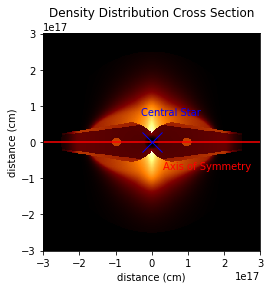

In [10]:
# 10 Density Display
plt.title("Density Distribution Cross Section")
plt.pcolormesh(x, y, Value, cmap = 'afmhot')
# plt.pcolormesh(x, y, Value, cmap = 'afmhot', norm = c.LogNorm(vmin = Value.max() / 1000000))
plt.annotate("Axis of Symmetry", xy = (view_length / 20, -view_length / 8), color = 'red')
plt.axhline(y = 0, color = 'red', linestyle = '-')
plt.annotate("Central Star", xy = (-view_length / 20, view_length / 8), color = 'blue')
plt.plot([0], [0], marker = "x", markersize = 20, color = "blue")
plt.gca().set_aspect('equal')
plt.xlabel("distance (cm)")
plt.ylabel("distance (cm)")
# plt.axis('on')
plt.show()

## Part 3. Computing The Optical Depth Arrays

In [11]:
# 11 Array Coordinate - Skyplane Coordinate Translations
def coord_to_index(x, y): 
    # coord_to_index(): Returns the array index i given the skyplane coordinates x, y in cm 
    return int(int(((x / view_size) + 1) * (resolution / 2)) + int((y / view_size) * (resolution / 2)) * (resolution + 1))
def index_to_x(i):
    # index_to_x(): Returns the skyplane coordinate x given the array index i
    return (int(i % (resolution + 1)) / (resolution / 2) - 1) * view_size
def index_to_y(i):
    # index_to_y(): Returns the skyplane coordinate y given the array index i
    return (int(i / (resolution + 1)) / (resolution / 2)) * view_size

In [12]:
# 12 Define Spherical Optical Depth Integration Function
def optical_depth_center_progression(latitude, distance):
    # optical_depth_center_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density(latitude, distance + i * (view_size / (distance_steps * absorption_steps_center)))
        sum += add # add the non constant density
        i += 1 / absorption_steps_center
    sum = scattering_effective_crosssection * sum * (2 * view_size / (distance_steps * absorption_steps_center))
    # now multiply the constants of the integrand
    return sum / albedo # divide the albedo for the total extinction crosssection

In [13]:
# 13 Spherical Optical Depth Array
# Define the spherical optical depth array
# i from 0 to distance_steps, represents distance from 0 to 2*view_size
# j from 0 to pi/2, represents the latitude
i, j = distance_steps + 1, angle_steps + 1
optical_depth_center_array = [[0 for x in range(i)] for y in range(j)]

100%|██████████| 1800/1800 [07:23<00:00,  4.05it/s]


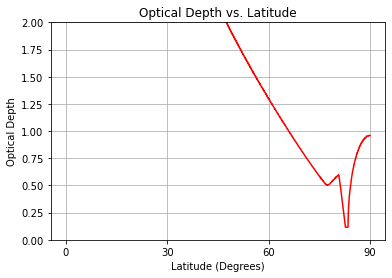

In [14]:
# 14 Computing The Required Spherical Optical Depth Array
# required = np.asarray(np.loadtxt('required_spherical_coordinates.csv', delimiter=' ')).astype('int')
for i in tqdm(range(0, angle_steps)):
    for j in range(0, distance_steps):
        
        # stdout.write("\rProgress: " + str(int(i / angle_steps + j / angle_steps / (distance_steps - 1))) + "%")
        # stdout.flush()
        
        # For each angle, accumulatively compute the optical depth
        add = optical_depth_center_progression(i * pi / (2 * angle_steps), j * (2 * view_size / distance_steps))
        optical_depth_center_array[i][j] = optical_depth_center_array[i][j - 1] + add

x_odc = np.linspace(0, 90, 1800)
y_odc = np.array([])
x = [0, 30, 60, 90]
for i in range(0, 1800):
    y_odc = np.append(y_odc, optical_depth_center_array[i][999])
plt.plot(x_odc, y_odc * 3.45, color = 'red')
plt.xticks(ticks = x)
plt.title("Optical Depth vs. Latitude")
plt.xlabel("Latitude (Degrees)")
plt.ylabel("Optical Depth")
plt.ylim(0, 2)
plt.grid()
plt.show()

In [15]:
# 15 Define Cubical Optical Depth Integration Function
n = 2 * view_size / resolution
def optical_depth_progression(x1, x2):
    # optical_depth_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density_cartesian(x1 + i * (x2 - x1))
        sum += add # add the non constant density
        i += 1 / absorption_steps
    sum = scattering_effective_crosssection * sum * n / absorption_steps # now multiply the constants of the integrand
    return sum / albedo # return the result

In [16]:
# 16 Cubical Optical Depth Array
# Define the cubical optical depth array
# j is the depth, "0" is the closest to the viewplane, "resolution" isthe deepest, resolution+1 steps in total
# i is the coordinate, is the x*(resolution+1)+y, minimum 0 (x minimum, y=0), maximum (resolution+1)*(resolution)-1 (top right corner)
# here x and y are pixel coordinates, from 0 to resolution
i, j = resolution + 1, (resolution + 1) * (int(resolution / 2) + 1)
optical_depth_array = [[0 for x in range(i)] for y in range(j)]

In [17]:
# 17 Computing The Partial Cubical Optical Depth Array
r = (resolution + 1) * (int(resolution / 2) + 1) - 1
required = np.asarray(np.loadtxt('required_coordinates.csv', delimiter = ' ')).astype('int')
for i in tqdm(required):
    for j in range(0, resolution):
        
        # stdout.write("\rProgress: " + str(np.int(i / r + j / r / (resolution - 1))) + "%")
        # stdout.flush()
        
        # For each coordinate, accumulate the optical depth along the line of sight
        x = index_to_x(i)
        y = index_to_y(i)
        
        add = optical_depth_progression(np.array([x * sin_obs_lat + (((resolution / 2) - j) / (resolution / 2) * view_size) * cos_obs_lat, y, -x * cos_obs_lat + (((resolution / 2) - j) / (resolution / 2) * view_size) * sin_obs_lat]), np.array([x * sin_obs_lat + (((resolution / 2) - (j - 1)) / (resolution / 2) * view_size) * cos_obs_lat, y, -x * cos_obs_lat + (((resolution / 2) - (j - 1)) / (resolution / 2) * view_size) * sin_obs_lat]))
        
        optical_depth_array[i][j] = optical_depth_array[i][j - 1] + add

100%|██████████| 1493/1493 [03:31<00:00,  7.06it/s]


## Part 4. Computing The Image

In [18]:
# 20 Defining the Optical Intensity Function
asymmetry_constant = 0.6
# The scattering asymmetry constant - Default : 0.5
# This can change with each recompute, without altering the array, mainly changing front/back ratio
scale_factor = 3.601806640625 # The post-compute multiplier applied to the density/optical depths array

@np.vectorize
def intensity(x, y):
    sum = 0.0
    # total number of unit photons reaching the specified pixel
    i = coord_to_index(x, y)
    for j in range(0, resolution):
        cur = np.array([float(x * sin_obs_lat + (((resolution / 2) - j) / (resolution / 2) * view_size) * cos_obs_lat), float(y), float(-x * cos_obs_lat + (((resolution / 2) - j) / (resolution / 2) * view_size) * sin_obs_lat)])
        # current point (precise value stored in array)
        spherical = cartesian_to_spherical(cur) 
        # spherical of current point, to find the optical depth center
        o_d_center = scale_factor * optical_depth_center_array[abs(int((angle_steps / 90) * (90 - (180 * spherical[1] / pi))))][int(spherical[0] / (2 * view_size) * distance_steps)]
        # optical depth from center
        o_d = scale_factor * optical_depth_array[i][j]
        # optical depth from point of interest to earth
        # the amount of photons from that point
        if x == 0 and y == 0 and j == resolution / 2: # point of interest is central star
            add = mpmath.exp(-scale_factor * optical_depth_array[coord_to_index(0, 0)][int(j)]) / ((view_length / resolution) * (view_length / resolution))
        else:
            add = (1 / (4 * pi * ((spherical[0]) * (spherical[0])))) * mpmath.exp(-o_d) * mpmath.exp(-o_d_center) * scale_factor * scattering_effective_crosssection * density(pi / 2 - spherical[1], spherical[0]) * (view_length / resolution) * phase_function(vector_angle(np.array([cos_obs_lat, 0, sin_obs_lat]), cur))
        sum += add
    return sum

In [19]:
data = fits.open("f547m_80s_raw_1.fits")[0].data[0]
            
n = 9

psf_x = 406
psf_y = 478
    
psf_profile = data[psf_x - n + 1 : psf_x + n, psf_y - n + 1 : psf_y + n][::-1, ::-1] / data[psf_x - n + 1 : psf_x + n, psf_y - n + 1 : psf_y + n].ravel().sum()

print(np.max(psf_profile))
print(psf_profile.ravel().sum())

0.1600421
0.99999994


0.13075531762529338
0.12569393272619367


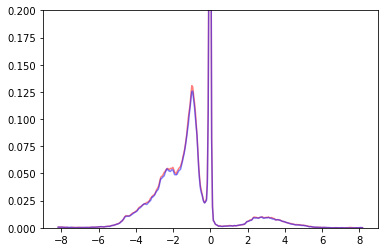

In [20]:
hst_image = fits.open("80_raw_1.fits")[0].data[0]

x_array = np.linspace(-angular_size, angular_size, real_resolution)

center_x = 412
center_y = 407

angle_degrees = 105

start_x = 150 + np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
end_x = 150 - np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
start_y = 150 + np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size
end_y = 150 - np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size

y_hst = skimage.measure.profile_line(hst_image[center_x - 150 : center_x + 150, center_y - 150 : center_y + 150], [start_x, start_y], [end_x, end_y], linewidth = 3)
x_hst = np.linspace(-(len(y_hst) - 1) / 2 *  pixel_size, (len(y_hst) - 1) / 2 *  pixel_size, len(y_hst))
y_hst = np.delete(y_hst, int(len(y_hst) / 2))
y_hst = np.insert(y_hst, int(len(y_hst) / 2), hst_image[center_x, center_y])
x_hst = np.delete(x_hst, int(len(y_hst) / 2))
x_hst = np.insert(x_hst, int(len(y_hst) / 2), 0)

y_hst_scaled = np.interp(x_array, x_hst, y_hst)

normalizedYHST = y_hst_scaled / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
plt.plot(x_array, normalizedYHST, color = 'red', alpha = 0.5, label = 'HST')

plt.ylim(0, 0.2)

true_star_value = float(np.max(normalizedYHST))
true_lobe_value = float(np.max(normalizedYHST[0 : int(len(normalizedYHST) / 2 - 3)]))
# print(star_value)
print(true_lobe_value)
# print(star_value / lobe_value)

hst_image = fits.open("80_raw_2.fits")[0].data[0]

x_array = np.linspace(-angular_size, angular_size, real_resolution)

center_x = 412
center_y = 407

angle_degrees = 105

start_x = 150 + np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
end_x = 150 - np.sin(angle_degrees * np.pi / 180) * angular_size / pixel_size
start_y = 150 + np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size
end_y = 150 - np.cos(angle_degrees * np.pi / 180) * angular_size / pixel_size

y_hst = skimage.measure.profile_line(hst_image[center_x - 150 : center_x + 150, center_y - 150 : center_y + 150], [start_x, start_y], [end_x, end_y], linewidth = 3)
x_hst = np.linspace(-(len(y_hst) - 1) / 2 *  pixel_size, (len(y_hst) - 1) / 2 *  pixel_size, len(y_hst))
y_hst = np.delete(y_hst, int(len(y_hst) / 2))
y_hst = np.insert(y_hst, int(len(y_hst) / 2), hst_image[center_x, center_y])
x_hst = np.delete(x_hst, int(len(y_hst) / 2))
x_hst = np.insert(x_hst, int(len(y_hst) / 2), 0)

y_hst_scaled = np.interp(x_array, x_hst, y_hst)

normalizedYHST = y_hst_scaled / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
plt.plot(x_array, normalizedYHST, color = 'blue', alpha = 0.5, label = 'HST')

plt.ylim(0, 0.2)

true_star_value = float(np.max(normalizedYHST))
true_lobe_value = float(np.max(normalizedYHST[0 : int(len(normalizedYHST) / 2 - 3)]))
# print(star_value)
print(true_lobe_value)

45.85997171690464
99.17104950018242
4
3290.686093248389
99.17104950018242
2
424.6716892084062
99.17104950018242
3.0
141.77186557671934
99.17104950018242
3.5
80.56681866865576
99.17104950018242
3.75
106.94162641447531
99.17104950018242
3.625
92.81026037791995
99.17104950018242
3.6875
99.62246118755188
99.17104950018242
3.65625
96.15528397794225
99.17104950018242
3.671875
97.87331784094837
99.17104950018242
3.6640625
98.74396366997371
99.17104950018242
3.66015625
99.18223447328269
99.17104950018242
3.658203125
98.96285563889573
99.17104950018242
3.6591796875
99.07248128318813
99.17104950018242
3.65869140625
99.12733443112567
99.17104950018242
3.658447265625
99.15477973108456
99.17104950018242
3.6583251953125
99.16849693989019
99.17104950018242
3.65826416015625
3.658233642578125


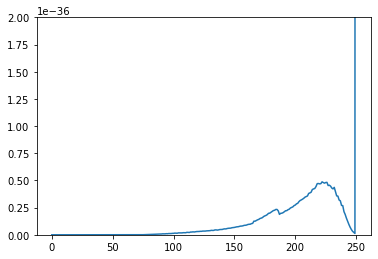

In [21]:
scale_factor = 4

scale_factor_increment = 2

found = False

kernel_center = np.max(psf_profile)

true_lobe_value = true_lobe_value

while(found == False):
    
    side = np.linspace(-view_size, 0, int(resolution / 2) + 1)
    sideY = np.linspace(0, 0, 1)
    x, y = np.meshgrid(side, sideY)
    np.seterr(divide = 'ignore')
    Value = np.asarray(intensity(x, y)).astype('float32')[0]
    
    star_value = float(np.max(Value))
    lobe_value = float(np.partition(Value, -2)[-2])
    
    ratio = star_value / lobe_value
    
    print(ratio)
    print(1 / kernel_center / true_lobe_value * (resolution ** 2 / real_resolution ** 2))
    print(scale_factor)
    
    if np.abs(ratio - 1 / kernel_center / true_lobe_value * (resolution ** 2 / real_resolution ** 2)) <= 0.01: 
        found = True
        
        plt.plot(Value)
        plt.ylim(0, 2e-36)
    
    if ratio >= 1 / kernel_center / true_lobe_value * (resolution ** 2 / real_resolution ** 2):
        scale_factor = scale_factor + scale_factor_increment
        scale_factor_increment = scale_factor_increment / 2
    else:
        scale_factor = scale_factor - scale_factor_increment
        scale_factor_increment = scale_factor_increment / 2
        
print(scale_factor)

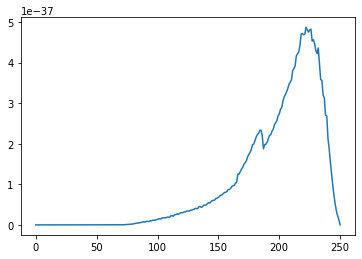

In [22]:
Value[-1] = 0
plt.plot(Value)

In [23]:
# 15 Define Cubical Optical Depth Integration Function
n = 2 * view_size / resolution
def optical_depth_progression(x1, x2):
    # optical_depth_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density_cartesian(x1 + i * (x2 - x1))
        sum += add # add the non constant density
        i += 1 / absorption_steps
    sum = scattering_effective_crosssection * sum * n / absorption_steps # now multiply the constants of the integrand
    return sum / albedo # return the result

In [24]:
# 16 Cubical Optical Depth Array
# Define the cubical optical depth array
# j is the depth, "0" is the closest to the viewplane, "resolution" isthe deepest, resolution+1 steps in total
# i is the coordinate, is the x*(resolution+1)+y, minimum 0 (x minimum, y=0), maximum (resolution+1)*(resolution)-1 (top right corner)
# here x and y are pixel coordinates, from 0 to resolution
i, j = resolution + 1, (resolution + 1) * (int(resolution / 2) + 1)
optical_depth_array = [[0 for x in range(i)] for y in range(j)]

In [25]:
# 17 Computing The Full Cubical Optical Depth Array
r = (resolution + 1) * (int(resolution / 2) + 1) - 1
for i in tqdm(range(0, r)):
    for j in range(0, resolution):
        remainder = i % (resolution + 1)
        if remainder > (resolution / 2):
            optical_depth_array[i][j] = optical_depth_array[int(i - 2 * (remainder - resolution / 2))][resolution - 1] - optical_depth_array[int(i - 2 * (remainder - resolution / 2))][resolution - 1 - j]
        
        # stdout.write("\rProgress: " + str(np.int(i / r + j / r / (resolution - 1))) + "%")
        # stdout.flush()
        
        # For each coordinate, accumulate the optical depth along the line of sight
        x = index_to_x(i)
        y = index_to_y(i)
        
        add = optical_depth_progression(np.array([x * sin_obs_lat + (((resolution / 2) - j) / (resolution / 2) * view_size) * cos_obs_lat, y, -x * cos_obs_lat + (((resolution / 2) - j) / (resolution / 2) * view_size) * sin_obs_lat]), np.array([x * sin_obs_lat + (((resolution / 2) - (j - 1)) / (resolution / 2) * view_size) * cos_obs_lat, y, -x * cos_obs_lat + (((resolution / 2) - (j - 1)) / (resolution / 2) * view_size) * sin_obs_lat]))
        
        optical_depth_array[i][j] = optical_depth_array[i][j - 1] + add

 38%|███▊      | 47515/125750 [1:42:18<1:28:14, 14.78it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 64%|██████▍   | 80975/125750 [2:22:22<1:12:22, 10.31it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [26]:
# 21 Computing The Top Half Image
side = np.linspace(-view_size, view_size, resolution + 1)
sideY = np.linspace(0, view_size, int(resolution / 2) + 1)
x, y = np.meshgrid(side, sideY)
np.seterr(divide = 'ignore')
Value = intensity(x, y) # compute half of the intensity map

In [27]:
# 22 Generating Full Image from Half Image
@np.vectorize
def findValue(x, y):
    cur_x = int((x / (angular_size) + 1) * resolution / 2)
    cur_y = round(y * resolution / angular_size / 2)
    if y > 0:
        return float(Value[cur_y][cur_x])
    elif y == 0:
        return float(Value[0][cur_x])
    else:
        return float(Value[-cur_y][cur_x])

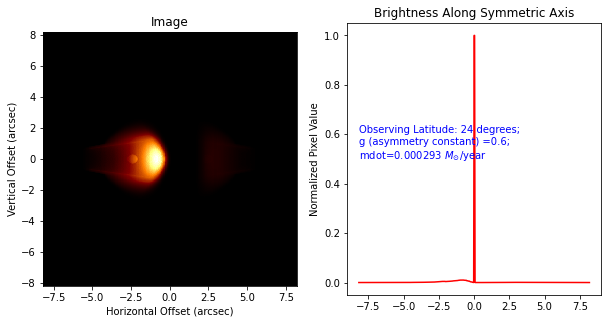

In [28]:
# 23 Plots
side_angular = np.linspace(-angular_size, angular_size, resolution + 1)
X, Y = np.meshgrid(side_angular, side_angular)
np.seterr(divide = 'ignore')
fullValues = findValue(X, Y)

f = plt.figure(figsize = (10, 5))
ax = f.add_subplot(121, aspect = 1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
plt.title("Image")
ax.pcolormesh(X, Y, fullValues, vmin = 0, vmax = np.max(fullValues[int(resolution / 2 + 1)][0 : int(resolution / 2 - 1)]), cmap = 'afmhot', shading = 'auto')
plt.gca().set_aspect('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-angular_size, angular_size, resolution + 1)
y_array = fullValues[int(resolution / 2)]
normalizedYArray = y_array / np.max(np.nan_to_num(np.array(y_array, dtype = float)))
ax2.plot(x_array, normalizedYArray, color = 'red')
x_pos = (1 + np.min(normalizedYArray)) / 2
ax2.set_ylabel("Normalized Pixel Value")
plt.title("Brightness Along Symmetric Axis")

plt.annotate("Observing Latitude: " + str(observing_latitude_degrees) + " degrees;\n" + "g (asymmetry constant) =" + str(asymmetry_constant) + ";\nmdot=" + str(round(mdot_solar_masses * scale_factor, 6)) + " " + '$ M_{\odot}$' + "/year", xy = (-angular_size, x_pos), color = 'blue')

# ax3 = ax2.twinx()
# ax3.plot(x_array, np.nan_to_num(np.array(y_array, dtype = float)), color = 'blue', alpha = 0)
# ax3.set_ylabel("Absolute Intensity (Not currently Implemented)")

plt.show()

In [29]:
# 25 Image Convolution

# Gaussian Convolution
kernel = Gaussian2DKernel(x_stddev = 3 / 500 * resolution, y_stddev = 3 / 500 * resolution)
astropy_conv = convolve(fullValues, kernel)

# PSF Convolution
# psf_conv = convolve2d(fullValues, psf_profile, mode = 'same')

In [30]:
import cv2

# Downscale
downscaled = cv2.resize(fullValues, (real_resolution, real_resolution), interpolation = cv2.INTER_AREA)

downscaled[int(real_resolution / 2)][int(real_resolution / 2)] = fullValues[int(resolution / 2)][int(resolution / 2)] * (real_resolution / resolution) ** 2

for dx in [-1, 0, 1]:
    for dy in [-1, 0, 1]:
        if dx == 0 and dy == 0:
            continue  # Skip the center pixel itself
        downscaled[int(real_resolution / 2) + dx, int(real_resolution / 2) + dy] = 0

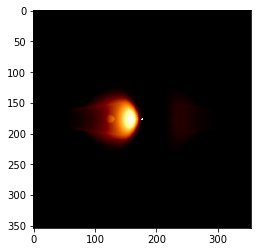

In [31]:
plt.imshow(downscaled, vmin = 0, vmax = np.max(fullValues[int(resolution / 2 + 1)][0 : int(resolution / 2 - 1)]), cmap = 'afmhot')

In [32]:
star_value = float(np.max(normalizedYHST))
lobe_value = float(np.max(normalizedYHST[0 : int(len(normalizedYHST) / 2 - 2)]))
print(star_value)
print(lobe_value)
print(star_value / lobe_value)

1.0
0.12569393272619367
7.9558334941938496


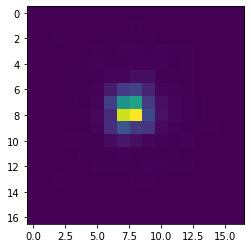

In [33]:
plt.imshow(psf_profile)

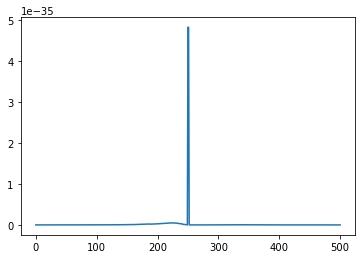

In [34]:
plt.plot(fullValues[int(resolution / 2)])

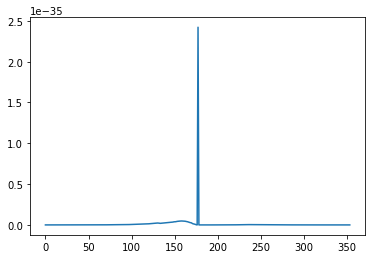

In [35]:
plt.plot(downscaled[int(real_resolution / 2)])

In [36]:
psf_conv = convolve2d(downscaled, psf_profile, mode = 'same')

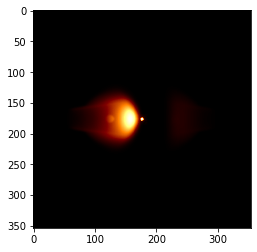

In [37]:
plt.imshow(psf_conv, vmin = 0, vmax = np.max(fullValues[int(resolution / 2 + 1)][0 : int(resolution / 2 - 1)]), cmap = 'afmhot')

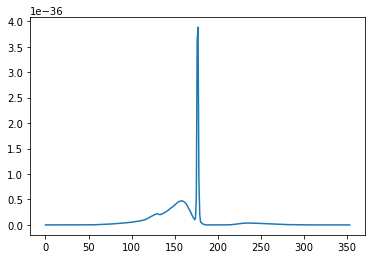

In [38]:
plt.plot(psf_conv[int(real_resolution / 2)])

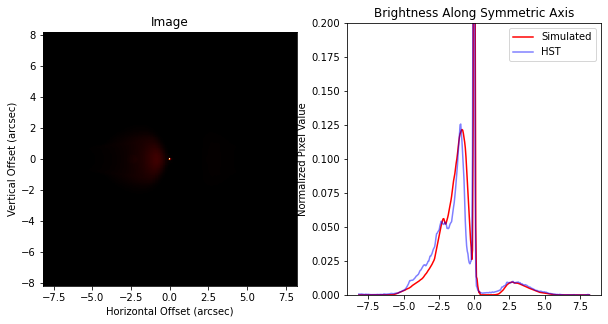

In [39]:
# 26 Plotting the Convoluted Image
f = plt.figure(figsize = (10, 5))
ax = f.add_subplot(121, aspect = 1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
plt.title("Image")

side_angular = np.linspace(-angular_size, angular_size, real_resolution)
X, Y = np.meshgrid(side_angular, side_angular)

ax.pcolormesh(X, Y, psf_conv, cmap = 'afmhot', shading = 'auto')
plt.gca().set_aspect('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-angular_size, angular_size, real_resolution)
y_array = psf_conv[int(real_resolution / 2)]
normalizedYArray = y_array / np.max(np.nan_to_num(np.array(y_array, dtype = float)))
ax2.plot(x_array, normalizedYArray, color = 'red', label = 'Simulated')
x_pos = (3 + np.min(normalizedYArray)) / 4
ax2.set_ylabel("Normalized Pixel Value")
plt.title("Brightness Along Symmetric Axis")

y_hst_scaled = np.interp(x_array, x_hst, y_hst)
normalizedYHST = y_hst_scaled / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))

ax2.plot(x_array, normalizedYHST, color = 'blue', alpha = 0.5, label = 'HST')

plt.annotate("Observing Latitude: " + str(observing_latitude_degrees) + " degrees;\n" + "g (asymmetry constant) =" + str(asymmetry_constant) + ";\nmdot=" + str(round(mdot_solar_masses * scale_factor, 6)) + " " + '$ M_{\odot}$' + "/year", xy = (-angular_size, x_pos), color = 'blue')

# ax3 = ax2.twinx()
# ax3.plot(x_array, np.nan_to_num(np.array(y_array, dtype = float)), color = 'blue', alpha = 0)
# ax3.set_ylabel("Absolute Intensity (Not currently Implemented)")

plt.ylim(0, 0.2)

plt.legend()
plt.show()

In [40]:
# 27 Saving Convolved Files
hdul = fits.PrimaryHDU(data = psf_conv / np.amax(psf_conv))
string = "1_convolved.fits"
hdul.writeto(string, overwrite = True)

In [41]:
# 29 Calculating Total Mass
total_mass = 0.0
x = -view_size
y = -view_size
z = -view_size
while x <= view_size:
    y = -view_size
    while y <= view_size:
        z = -view_size
        while z <= view_size:
            total_mass = total_mass + density_cartesian(np.array([x,y,z]))
            z += 1e16
        y += 1e16
    x += 1e16
total_mass = total_mass * 1e48 * grain_mass / dust_to_gas * scale_factor
print("Total Mass is: " + str(total_mass / 2e33))

Total Mass is: 1.63927398891981


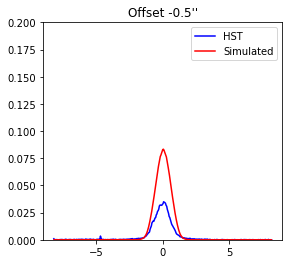

In [42]:
offset = -0.5

start_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size + cos(angle_degrees * pi / 180) * angular_size / pixel_size
end_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size - cos(angle_degrees * pi / 180) * angular_size / pixel_size
start_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size - sin(angle_degrees * pi / 180) * angular_size / pixel_size
end_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size + sin(angle_degrees * pi / 180) * angular_size / pixel_size

y_array = skimage.measure.profile_line(hst_image[center_x - 200 : center_x + 200, center_y - 200 : center_y + 200], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array) - 1) / 2 * pixel_size, -(len(y_array) - 1) / 2 * pixel_size, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float))), color = 'blue', label = "HST")
plt.title(f"Offset {offset}\'\'")

y_array = skimage.measure.profile_line(psf_conv, [real_resolution, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [0, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], linewidth = 1)
x_array = np.linspace(-angular_size, angular_size, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(psf_conv[int(real_resolution / 2)], dtype = float))), color = 'red', label = "Simulated")
plt.gca().set_aspect(2 * angular_size / 0.2)
plt.ylim([0, 0.2])
plt.legend()
plt.show()

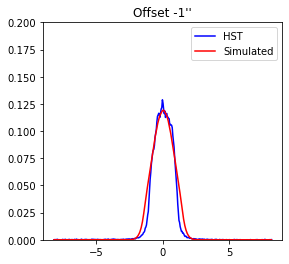

In [43]:
offset = -1

start_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size + cos(angle_degrees * pi / 180) * angular_size / pixel_size
end_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size - cos(angle_degrees * pi / 180) * angular_size / pixel_size
start_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size - sin(angle_degrees * pi / 180) * angular_size / pixel_size
end_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size + sin(angle_degrees * pi / 180) * angular_size / pixel_size

y_array = skimage.measure.profile_line(hst_image[center_x - 200 : center_x + 200, center_y - 200 : center_y + 200], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array) - 1) / 2 * pixel_size, -(len(y_array) - 1) / 2 * pixel_size, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float))), color = 'blue', label = "HST")
plt.title(f"Offset {offset}\'\'")

y_array = skimage.measure.profile_line(psf_conv, [real_resolution, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [0, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], linewidth = 1)
x_array = np.linspace(-angular_size, angular_size, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(psf_conv[int(real_resolution / 2)], dtype = float))), color = 'red', label = "Simulated")
plt.gca().set_aspect(2 * angular_size / 0.2)
plt.ylim([0, 0.2])
plt.legend()
plt.show()

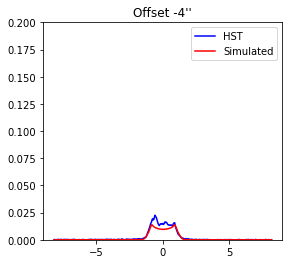

In [44]:
offset = -4

start_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size + cos(angle_degrees * pi / 180) * angular_size / pixel_size
end_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size - cos(angle_degrees * pi / 180) * angular_size / pixel_size
start_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size - sin(angle_degrees * pi / 180) * angular_size / pixel_size
end_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size + sin(angle_degrees * pi / 180) * angular_size / pixel_size

y_array_4 = skimage.measure.profile_line(hst_image[center_x - 200 : center_x + 200, center_y - 200 : center_y + 200], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array_4) - 1) / 2 * pixel_size, -(len(y_array_4) - 1) / 2 * pixel_size, len(y_array_4))
y_array_4 = y_array_4 / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
plt.plot(x_array, y_array_4, color = 'blue', label = "HST")
plt.title(f"Offset {offset}\'\'")

y_array_calculated_4 = skimage.measure.profile_line(psf_conv, [real_resolution, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [0, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], linewidth = 1)
x_array = np.linspace(-angular_size, angular_size, len(y_array_calculated_4))
y_array_calculated_4 = y_array_calculated_4 / np.max(np.nan_to_num(np.array(psf_conv[int(real_resolution / 2)], dtype = float)))
plt.plot(x_array, y_array_calculated_4, color = 'red', label = "Simulated")
plt.gca().set_aspect(2 * angular_size / 0.2)
plt.ylim([0, 0.2])
plt.legend()
plt.show()

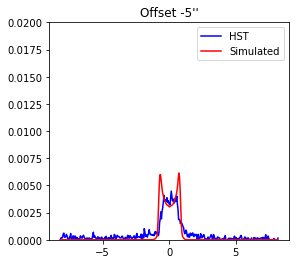

In [45]:
offset = -5

start_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size + cos(angle_degrees * pi / 180) * angular_size / pixel_size
end_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size - cos(angle_degrees * pi / 180) * angular_size / pixel_size
start_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size - sin(angle_degrees * pi / 180) * angular_size / pixel_size
end_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size + sin(angle_degrees * pi / 180) * angular_size / pixel_size

y_array_5 = skimage.measure.profile_line(hst_image[center_x - 200 : center_x + 200, center_y - 200 : center_y + 200], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array_5) - 1) / 2 * pixel_size, -(len(y_array_5) - 1) / 2 * pixel_size, len(y_array_5))
plt.plot(x_array, y_array_5 / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float))), color = 'blue', label = "HST")
plt.title(f"Offset {offset}\'\'")

y_array_calculated_5 = skimage.measure.profile_line(psf_conv, [real_resolution, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [0, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], linewidth = 1)
x_array = np.linspace(-angular_size, angular_size, len(y_array_calculated_5))
plt.plot(x_array, y_array_calculated_5 / np.max(np.nan_to_num(np.array(psf_conv[int(real_resolution / 2)], dtype = float))), color = 'red', label = "Simulated")
plt.gca().set_aspect(2 * angular_size / 0.02)
plt.ylim([0, 0.02])
plt.legend()
plt.show()

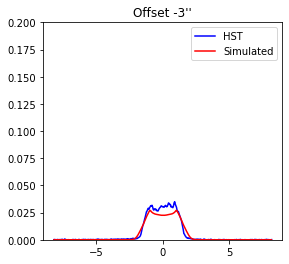

In [46]:
offset = -3

start_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size + cos(angle_degrees * pi / 180) * angular_size / pixel_size
end_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size - cos(angle_degrees * pi / 180) * angular_size / pixel_size
start_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size - sin(angle_degrees * pi / 180) * angular_size / pixel_size
end_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size + sin(angle_degrees * pi / 180) * angular_size / pixel_size

y_array_3 = skimage.measure.profile_line(hst_image[center_x - 200 : center_x + 200, center_y - 200 : center_y + 200], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array_3) - 1) / 2 * pixel_size, -(len(y_array_3) - 1) / 2 * pixel_size, len(y_array_3))
y_array_3 = y_array_3 / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
plt.plot(x_array, y_array_3, color = 'blue', label = "HST")
plt.title(f"Offset {offset}\'\'")

y_array_calculated_3 = skimage.measure.profile_line(psf_conv, [real_resolution, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [0, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], linewidth = 1)
x_array = np.linspace(-angular_size, angular_size, len(y_array_calculated_3))
y_array_calculated_3 = y_array_calculated_3 / np.max(np.nan_to_num(np.array(psf_conv[int(real_resolution / 2)], dtype = float)))
plt.plot(x_array, y_array_calculated_3, color = 'red', label = "Simulated")
plt.gca().set_aspect(2 * angular_size / 0.2)
plt.ylim([0, 0.2])
plt.legend()
plt.show()

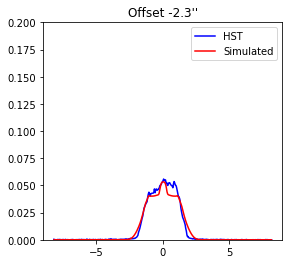

In [47]:
offset = -2.3

start_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size + cos(angle_degrees * pi / 180) * angular_size / pixel_size
end_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size - cos(angle_degrees * pi / 180) * angular_size / pixel_size
start_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size - sin(angle_degrees * pi / 180) * angular_size / pixel_size
end_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size + sin(angle_degrees * pi / 180) * angular_size / pixel_size

y_array = skimage.measure.profile_line(hst_image[center_x - 200 : center_x + 200, center_y - 200 : center_y + 200], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array) - 1) / 2 * pixel_size, -(len(y_array) - 1) / 2 * pixel_size, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float))), color = 'blue', label = "HST")
plt.title(f"Offset {offset}\'\'")

y_array = skimage.measure.profile_line(psf_conv, [real_resolution, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [0, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], linewidth = 1)
x_array = np.linspace(-angular_size, angular_size, len(y_array))
plt.plot(x_array, y_array / np.max(np.nan_to_num(np.array(psf_conv[int(real_resolution / 2)], dtype = float))), color = 'red', label = "Simulated")
plt.gca().set_aspect(2 * angular_size / 0.2)
plt.ylim([0, 0.2])
plt.legend()
plt.show()

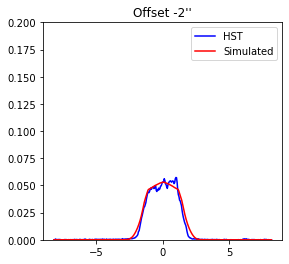

In [48]:
offset = -2

start_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size + cos(angle_degrees * pi / 180) * angular_size / pixel_size
end_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size - cos(angle_degrees * pi / 180) * angular_size / pixel_size
start_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size - sin(angle_degrees * pi / 180) * angular_size / pixel_size
end_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size + sin(angle_degrees * pi / 180) * angular_size / pixel_size

y_array_2 = skimage.measure.profile_line(hst_image[center_x - 200 : center_x + 200, center_y - 200 : center_y + 200], [start_x, start_y], [end_x, end_y], linewidth = 1)
x_array = np.linspace((len(y_array_2) - 1) / 2 * pixel_size, -(len(y_array_2) - 1) / 2 * pixel_size, len(y_array_2))
y_array_2 = y_array_2 / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
plt.plot(x_array, y_array_2, color = 'blue', label = "HST")
plt.title(f"Offset {offset}\'\'")

y_array_calculated_2 = skimage.measure.profile_line(psf_conv, [real_resolution, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [0, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], linewidth = 1)
x_array = np.linspace(-angular_size, angular_size, len(y_array_calculated_2))
y_array_calculated_2 = y_array_calculated_2 / np.max(np.nan_to_num(np.array(psf_conv[int(real_resolution / 2)], dtype = float)))
plt.plot(x_array, y_array_calculated_2, color = 'red', label = "Simulated")
plt.gca().set_aspect(2 * angular_size / 0.2)
plt.ylim([0, 0.2])
plt.legend()
plt.show()

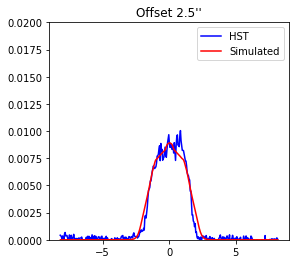

In [49]:
offset = 2.5

start_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size + cos(angle_degrees * pi / 180) * angular_size / pixel_size
end_x = 200 - sin(angle_degrees * pi / 180) * offset / pixel_size - cos(angle_degrees * pi / 180) * angular_size / pixel_size
start_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size - sin(angle_degrees * pi / 180) * angular_size / pixel_size
end_y = 200 - cos(angle_degrees * pi / 180) * offset / pixel_size + sin(angle_degrees * pi / 180) * angular_size / pixel_size

y_array_neg_2p5 = skimage.measure.profile_line(hst_image[center_x - 200 : center_x + 200, center_y - 200 : center_y + 200], [start_x, start_y], [end_x, end_y], linewidth = 1)
y_array_neg_2p5 = y_array_neg_2p5 / np.max(np.nan_to_num(np.array(y_hst_scaled, dtype = float)))
x_array = np.linspace((len(y_array_neg_2p5) - 1) / 2 * pixel_size, -(len(y_array_neg_2p5) - 1) / 2 * pixel_size, len(y_array_neg_2p5))
plt.plot(x_array, y_array_neg_2p5, color = 'blue', label = "HST")
plt.title(f"Offset {offset}\'\'")

y_array_calculated_neg_2p5 = skimage.measure.profile_line(psf_conv, [real_resolution, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [0, real_resolution / 2 + offset * real_resolution / (angular_size * 2)], linewidth = 1)
x_array = np.linspace(-angular_size, angular_size, len(y_array_calculated_neg_2p5))
y_array_calculated_neg_2p5 = y_array_calculated_neg_2p5 / np.max(np.nan_to_num(np.array(psf_conv[int(real_resolution / 2)], dtype = float)))
plt.plot(x_array, y_array_calculated_neg_2p5, color = 'red', label = "Simulated")
plt.gca().set_aspect(2 * angular_size / 0.02)
plt.ylim([0, 0.02])
plt.legend()
plt.show()

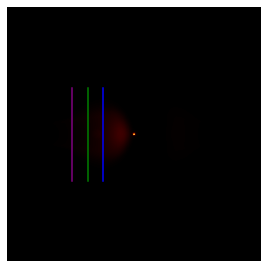

In [50]:
f = plt.figure(figsize = (10, 5))
ax = f.add_subplot(121, aspect = 1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
# plt.title("Image")
plt.imshow(psf_conv, cmap = 'afmhot')
plt.gca().set_aspect('equal')
plt.axis('off')
offset = -4
plt.plot([real_resolution / 2 + offset * real_resolution / (angular_size * 2), real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [real_resolution / 2 + 3 * real_resolution / (angular_size * 2), real_resolution / 2 - 3 * real_resolution / (angular_size * 2)], color = "purple")
offset = -3
plt.plot([real_resolution / 2 + offset * real_resolution / (angular_size * 2), real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [real_resolution / 2 + 3 * real_resolution / (angular_size * 2), real_resolution / 2 - 3 * real_resolution / (angular_size * 2)], color = "green")
offset = -2
plt.plot([real_resolution / 2 + offset * real_resolution / (angular_size * 2), real_resolution / 2 + offset * real_resolution / (angular_size * 2)], [real_resolution / 2 + 3 * real_resolution / (angular_size * 2), real_resolution / 2 - 3 * real_resolution / (angular_size * 2)], color = "blue")

In [51]:
x_array_calculated = np.linspace(-angular_size, angular_size, resolution + 1)

x_array = np.linspace(-(len(y_array_neg_2p5) - 1) / 2 * pixel_size, (len(y_array_neg_2p5) - 1) / 2 * pixel_size, len(y_array_neg_2p5))
y_array_neg_2p5 = np.interp(x_array_calculated, x_array, y_array_neg_2p5)
x_array = np.linspace(-(len(y_array_4) - 1) / 2 * pixel_size, (len(y_array_4) - 1) / 2 * pixel_size, len(y_array_4))
y_array_4 = np.interp(x_array_calculated, x_array, y_array_4)
x_array = np.linspace(-(len(y_array_3) - 1) / 2 * pixel_size, (len(y_array_3) - 1) / 2 * pixel_size, len(y_array_3))
y_array_3 = np.interp(x_array_calculated, x_array, y_array_3)
x_array = np.linspace(-(len(y_array_2) - 1) / 2 * pixel_size, (len(y_array_2) - 1) / 2 * pixel_size, len(y_array_2))
y_array_2 = np.interp(x_array_calculated, x_array, y_array_2)

score_1 = abs((np.sum(normalizedYArray) - np.sum(normalizedYHST)) / np.sum(normalizedYHST))
print("Symmetric Axis Area Score: " + str(score_1))
score_2 = abs((np.sum(y_array_calculated_4[int(resolution / 3) : resolution + 1 - int(resolution / 3)]) - np.sum(y_array_4[int(resolution / 3) : resolution + 1 - int(resolution / 3)])) / np.sum(y_array_4[int(resolution / 3) : resolution + 1 - int(resolution / 3)]))
print("-4\'\' Area Score: " + str(score_2))
score_3 = abs((np.sum(y_array_calculated_3[int(resolution / 3) : resolution + 1 - int(resolution / 3)]) - np.sum(y_array_3[int(resolution / 3) : resolution + 1 - int(resolution / 3)])) / np.sum(y_array_3[int(resolution / 3) : resolution + 1 - int(resolution / 3)]))
print("-3\'\' Area Score: " + str(score_3))
score_4 = abs((np.sum(y_array_calculated_2[int(resolution / 3) : resolution + 1 - int(resolution / 3)]) - np.sum(y_array_2[int(resolution / 3) : resolution + 1 - int(resolution / 3)])) / np.sum(y_array_2[int(resolution / 3) : resolution + 1 - int(resolution / 3)]))
print("-2\'\' Area Score: " + str(score_4))
score_5 = abs((np.sum(y_array_calculated_neg_2p5[int(resolution / 3) : resolution + 1 - int(resolution / 3)]) - np.sum(y_array_neg_2p5[int(resolution / 3) : resolution + 1 - int(resolution / 3)])) / np.sum(y_array_neg_2p5[int(resolution / 3) : resolution + 1 - int(resolution / 3)]))
print("2.5\'\' Area Score: " + str(score_5))
weighted_score = score_1 * 10 / 17 + score_2 * 1 / 17 + score_3 * 2 / 17 + score_4 * 2 / 17 + score_5 * 2 / 17
print("Weighted Area Score: " + str(weighted_score))

Symmetric Axis Area Score: 0.12264965120408487
-4'' Area Score: 0.6358571463918609
-3'' Area Score: 0.5847676901226926
-2'' Area Score: 0.478374176467771
2.5'' Area Score: 0.504598144404731
Weighted Area Score: 0.2939902164954764


In [52]:
rms_score_1 = sqrt(np.square(np.subtract(normalizedYArray, normalizedYHST)).mean())
print("Symmetric Axis RMS Score: " + str(rms_score_1))
rms_score_2 = sqrt(np.square(np.subtract(y_array_calculated_4[int(resolution / 3) : resolution + 1 - int(resolution / 3)], y_array_4[int(resolution / 3) : resolution + 1 - int(resolution / 3)])).sum() / (resolution + 1))
print("-4\'\' RMS Score: " + str(rms_score_2))
rms_score_3 = sqrt(np.square(np.subtract(y_array_calculated_3[int(resolution / 3) : resolution + 1 - int(resolution / 3)], y_array_3[int(resolution / 3) : resolution + 1 - int(resolution / 3)])).sum() / (resolution + 1))
print("-3\'\' RMS Score: " + str(rms_score_3))
rms_score_4 = sqrt(np.square(np.subtract(y_array_calculated_2[int(resolution / 3) : resolution + 1 - int(resolution / 3)], y_array_2[int(resolution / 3) : resolution + 1 - int(resolution / 3)])).sum() / (resolution + 1))
print("-2\'\' RMS Score: " + str(rms_score_4))
rms_score_5 = sqrt(np.square(np.subtract(y_array_calculated_neg_2p5[int(resolution / 3) : resolution + 1 - int(resolution / 3)], y_array_neg_2p5[int(resolution / 3) : resolution + 1 - int(resolution / 3)])).sum() / (resolution + 1))
print("2.5\'\' RMS Score: " + str(rms_score_5))
weighted_rms_score = rms_score_1 * 10 / 17 + rms_score_2 * 1 / 17 + rms_score_3 * 2 / 17 + rms_score_4 * 2 / 17 + rms_score_5 * 2 / 17
print("Weighted RMS Score: " + str(weighted_rms_score))

Symmetric Axis RMS Score: 0.038171952433289205
-4'' RMS Score: 0.006266969051948044
-3'' RMS Score: 0.013101504530758366
-2'' RMS Score: 0.022874719723375334
2.5'' RMS Score: 0.003706710294568088
Weighted RMS Score: 0.027491315440131982


In [53]:
# END